In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform

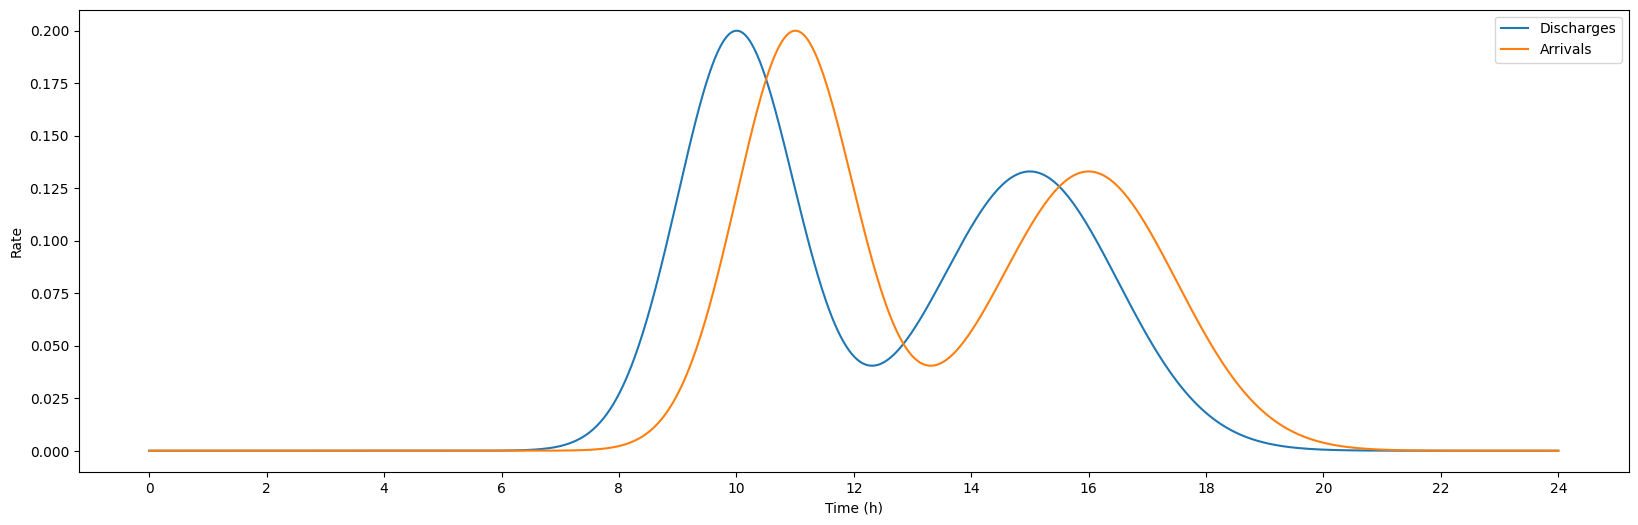

In [2]:
p = 0.55
t = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t, discharge_dist.pdf(t), label="Discharges")
ax.plot(t, admission_dist.pdf(t), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

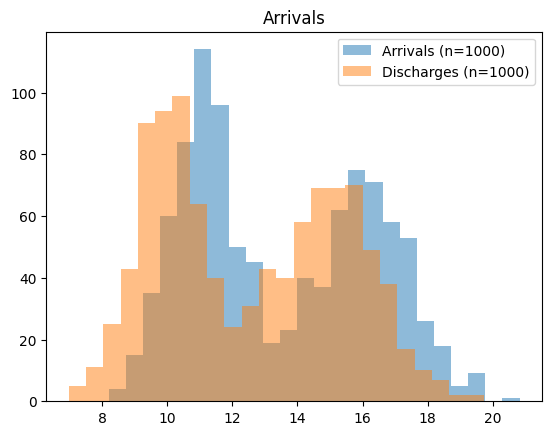

In [3]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [10]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm import tqdm

## Timeline of a bed
All the while the bed may have to wait for available transport and washing. 
- Patient is admitted to the hospital and occupies a bed.
- Patient is discharged, and the bed is sent to the logistics floor.
- Bed is transported from the elevator to the washing area.
- Bed is washed.
- Bed is transported back to the elevator.

In [269]:
@dataclass
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time

@dataclass
class BedLeaveElevator(Event):
    pass

@dataclass
class BedArrivedWashing(Event):
    pass

@dataclass
class BedFinishedWashing(Event):
    pass

@dataclass
class BedArriveElevator(Event):
    pass


In [35]:
def plot_queue_length(results):
    plt.figure(figsize=(12, 6))
    plt.title('Queue Length Over Time in Blocking System')
    # for run in results:
    plt.plot(results[1], results[2], label='Queue Length')
    
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.show()



## Current assumptions
- Bot teleports when not pushing bed
- Transportation time only occurs over the 175m distance in logistic room, e.g. not elevator to dirty buffer


## Issues
- What happens if two beds come immediately after each other? 
    - The bot should be occupied with the first bed until it is done, so the second bed should wait.

1


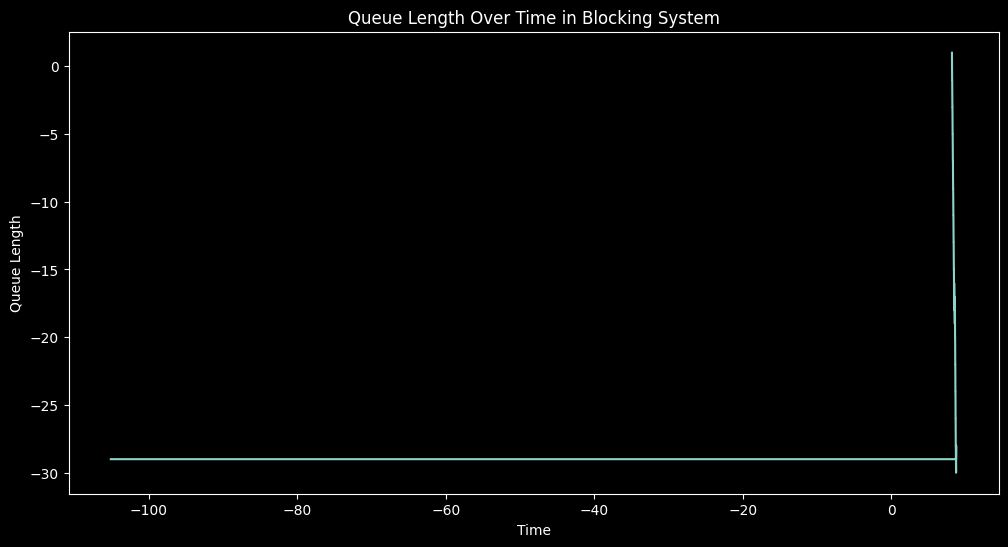

[BedLeaveElevator(time=8.1498467598306),
 BedArrivedWashing(time=8.158068618127462),
 BedArrivedWashing(time=8.166290476424324),
 BedFinishedWashing(time=8.166401951460912),
 BedArrivedWashing(time=8.174512334721186),
 BedArrivedWashing(time=8.182734193018048),
 BedFinishedWashing(time=8.18284566816896),
 BedArrivedWashing(time=8.19095605131491),
 BedArrivedWashing(time=8.199177909611771),
 BedFinishedWashing(time=8.199289384654055),
 BedArrivedWashing(time=8.207399767908633),
 BedArrivedWashing(time=8.215621626205495),
 BedFinishedWashing(time=8.21573310126579),
 BedArrivedWashing(time=8.223843484502357),
 BedArrivedWashing(time=8.232065342799219),
 BedFinishedWashing(time=8.232176818115713),
 BedArrivedWashing(time=8.24028720109608),
 BedArrivedWashing(time=8.248509059392942),
 BedFinishedWashing(time=8.248620534533195),
 BedArrivedWashing(time=8.256730917689804),
 BedArrivedWashing(time=8.264952775986666),
 BedFinishedWashing(time=8.265064251053506),
 BedArrivedWashing(time=8.273174

In [274]:
# def decision_policy(event, dirty_buffer, clean_buffer, washer_ready, bots_available):
#     if dirty_buffer == 0 and clean_buffer > 0:
#         return BedArriveElevator
#     if dirty_buffer > 0 and clean_buffer == 0:
#         return BedArrivedWashing if washer_ready else BedLeaveElevator
#     return BedFinishedWashing if np.random.rand() < 0.5 else BedArriveElevator

def simulate_system(
        admission_dist : callable,
        discharge_dist : callable,
        service_time_dist : callable,
        transport_time_dist : callable,
        n_patients: int = 200
    ):

    admission_times = admission_dist.rvs(size=n_patients)
    discharge_times = discharge_dist.rvs(size=n_patients)

    # events = [PatientAdmitted(time, 0) for time in admission_times]
    events = [BedLeaveElevator(time) for time in discharge_times]
    heapify(events)

    events_processed = []

    dirty_buffer = 0
    clean_buffer = 0
    
    buffer_sizes = []
    times = []

    washer_ready = True
    bots_available = 1

    iterations = 0
    while events:
        iterations += 1
        if iterations > 10000:
            break
        event = heappop(events)
        
        match event:
            case BedLeaveElevator(time=t):
                dirty_buffer += 1
                transport_time = transport_time_dist()  # Elevator -> Washing
                if bots_available > 0:
                    bots_available -= 1
                    heappush(events, BedArrivedWashing(t + transport_time))
            
            case BedArrivedWashing(time=t):
                bots_available += 1
                if washer_ready:
                    washer_ready = False
                    dirty_buffer -= 1
                    
                    heappush(events, BedFinishedWashing(t + service_time_dist()))
                
                assert bots_available > 0, "NO BOTS AVAILABLE!!! ERROR"                
                bots_available -= 1
                heappush(events, BedArrivedWashing(t + transport_time))
                    
            case BedFinishedWashing(time=t):
                clean_buffer += 1

                if washer_ready and dirty_buffer > 0:
                    washer_ready = False
                    dirty_buffer -= 1
                    
                    transport_time = ()  # Clean buffer -> ward
                    heappush(events, BedFinishedWashing(t + service_time_dist()))
                else:
                    washer_ready = True
                
                if bots_available > 0:
                    transport_time = transport_time_dist()  # Clean buffer -> ward
                    heappush(events, BedArriveElevator(t + transport_time))  # Clean bed arrives at elevator
            
            case BedArriveElevator(time=t):
                clean_buffer -= 1

                # bots_available += 1

                # assert bots_available > 0, "NO BOTS AVAILABLE!!! ERROR"                
                # bots_available -= 1
                # heappush(events, BedArrivedWashing(t + transport_time))
        
        buffer_sizes.append(dirty_buffer)
        times.append(event.time)
            

        events_processed.append(event)

    return events_processed, np.array(times), np.array(buffer_sizes)

# np.random.seed(42)
service_min_time = 1/120  # 10 minute
service_time_dist = lambda: service_min_time + expon(scale=1e-10).rvs()
transport_time_dist = lambda: norm(loc=1/120, scale=1e-2).rvs()  # 1/2 minute to transport a bed

results = simulate_system(admission_dist, discharge_dist, service_time_dist, transport_time_dist, n_patients=200)
print(f"{np.max(results[2])}")  # 10
plot_queue_length(results)
results[0]

# Looking at distributions

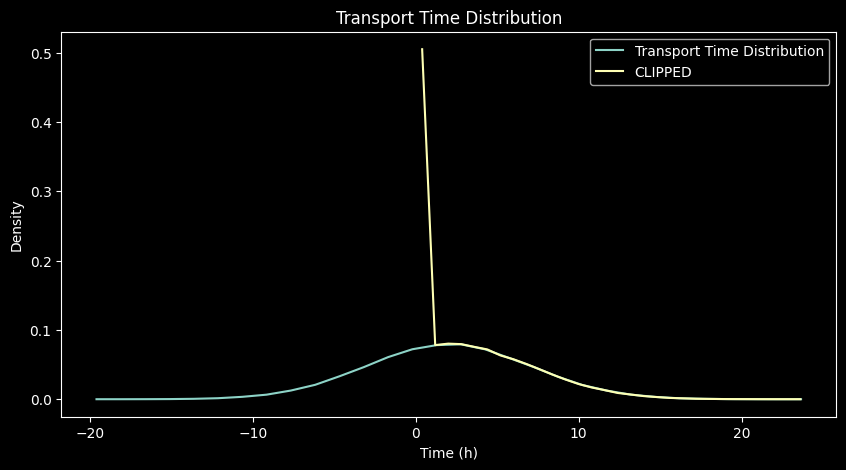

In [222]:
# plot transport_time_dist
def plot_transport_time_dist():
    # sample 100 samples
    samples = norm(loc=2, scale=5).rvs(size=113000)
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    # Center the bins for plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    samples = np.clip(samples, 0, 24)  # Clip to 24 hours
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.plot(t, y, label="CLIPPED")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()

124.00000000000001
124.10722756451115 133.38903130519842 125.13387827965883


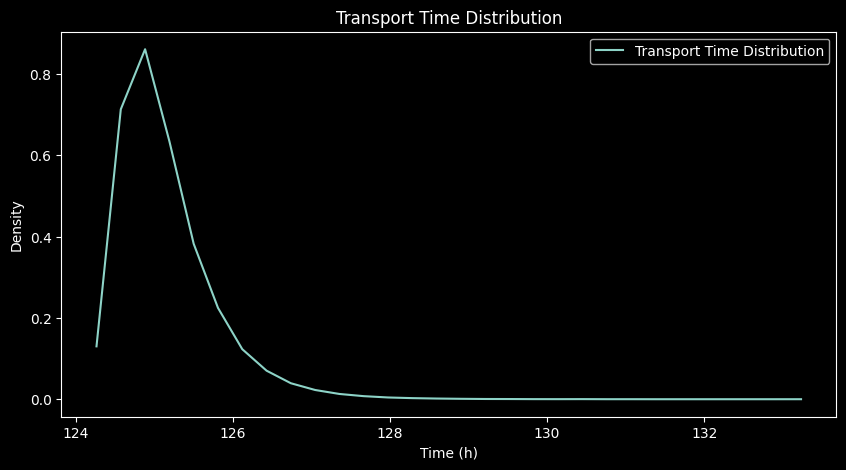

In [ ]:
from scipy.stats import lognorm
def plot_transport_time_dist():
    # 175 [m] / 1.4 [m/s]
    loc = (175 / 1.4 - 1)
    print(loc)
    # sample 100 samples
    samples = lognorm(loc=loc, s=.5).rvs(size=100000)# / 60 / 60
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist() # 125.13387827965883

1.0000364749224109 5.479084251025757 1.7987631225633336


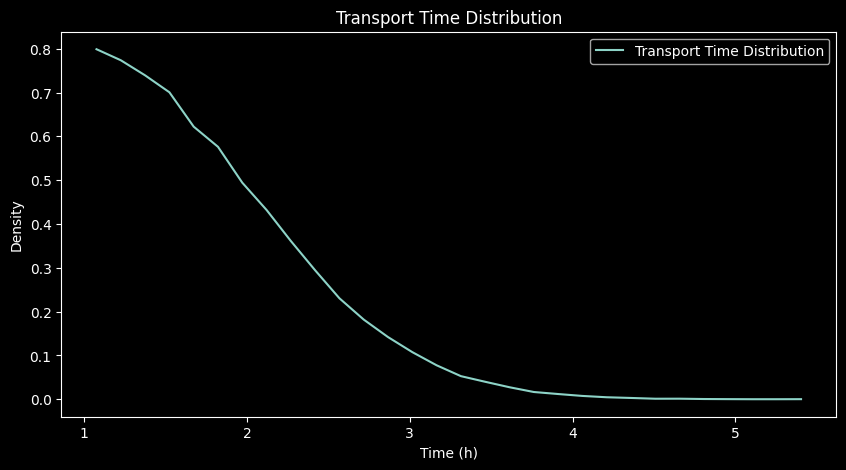

In [247]:
from scipy.stats import halfnorm
def plot_transport_time_dist():
    # sample 100 samples
    samples = halfnorm(loc=1, scale=1).rvs(size=100000)
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()